In [1]:
import causalimpact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
# Set the random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 200  # total number of points
change_point = int(0.7 * n_points)  # point of intervention
slope_pre = 0.5  # slope before intervention
slope_post = 0.5  # slope after intervention
#slope_pre = 0  # slope before intervention
#slope_post = 0  # slope after intervention
intercept_pre = 5  # intercept before intervention
#intercept_pre = 0  # intercept before intervention
jump_at_intervention = 0.5  # sudden jump at the intervention point
noise_level = 2.0  # noise level in the data

# Seasonal parameters
seasonality_period = 12  # typical monthly seasonality
seasonal_amplitude = 3  # amplitude of the seasonal component

# Time periods
time = np.arange(n_points)

# Generating the seasonal component
seasonal_component = seasonal_amplitude * np.sin(2 * np.pi * time / seasonality_period)

# Generating the data
data_pre = (slope_pre * time[:change_point] + intercept_pre + seasonal_component[:change_point] +
            np.random.normal(scale=noise_level, size=change_point))
data_post = (slope_post * time[change_point:] + intercept_pre + jump_at_intervention + 
             seasonal_component[change_point:] + np.random.normal(scale=noise_level, size=n_points - change_point))

# Concatenating the pre and post intervention data
data = np.concatenate([data_pre, data_post])

# Generating the control data without the intervention jump
control_data_pre = slope_pre * time[:change_point] + intercept_pre + seasonal_component[:change_point] + np.random.normal(scale=noise_level, size=change_point)
control_data_post = slope_pre * time[change_point:] + intercept_pre + seasonal_component[change_point:] + np.random.normal(scale=noise_level, size=n_points - change_point)

# Concatenating the pre and post control data
control_data = np.concatenate([control_data_pre, control_data_post])

In [20]:
# Creating a pandas DataFrame
ts_data = pd.DataFrame(data, columns=['Value'])
ts_data['Time'] = pd.date_range(start='2021-01-01', periods=n_points, freq='D')
ts_data['Control_Value'] = control_data

ts_data.head(), ts_data.tail(), change_point

(      Value       Time  Control_Value
 0  1.203153 2021-01-01       0.345955
 1  1.431600 2021-01-02       2.253606
 2  4.099985 2021-01-03       4.397873
 3  6.250996 2021-01-04       4.742955
 4  2.333110 2021-01-05      -0.520255,
         Value       Time  Control_Value
 195  4.169130 2021-07-15       2.015078
 196  1.227260 2021-07-16      -0.873107
 197  2.202753 2021-07-17       4.164488
 198  0.510124 2021-07-18      -0.270680
 199 -3.393830 2021-07-19       0.935689,
 140)

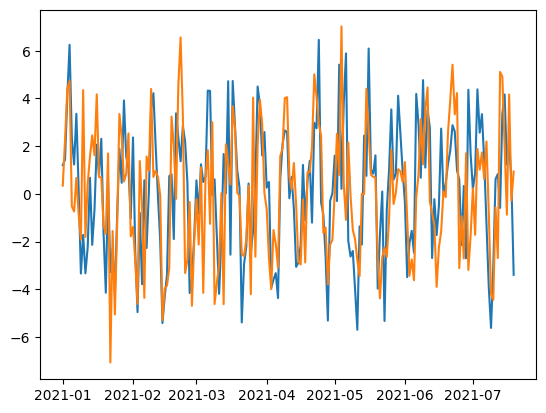

In [21]:
plt.plot(ts_data["Time"], ts_data["Value"])
plt.plot(ts_data["Time"], ts_data["Control_Value"])
plt.show()

In [22]:
df = ts_data.rename(columns={"Value": "y", "Control_Value": "X"}).set_index("Time")

In [23]:
%%time
c = causalimpact.fit_causalimpact(
    df,
    pre_period=["20210101", "20210521"],
    post_period=["20210522", "20210719"],
    inference_options=causalimpact.InferenceOptions(num_results=10000)
)

CPU times: user 8.08 s, sys: 792 ms, total: 8.87 s
Wall time: 3.85 s


In [7]:
causalimpact.plot(c)

alt.FacetChart(...)

In [24]:
causalimpact.plot(c)

alt.FacetChart(...)

In [8]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    90.7               5348.9
Prediction (s.d.)         89.4 (1.95)        5276.4 (115.0)
95% CI                    [85.6, 93.2]       [5049.0, 5498.7]

Absolute effect (s.d.)    1.2 (1.95)         72.5 (115.0)
95% CI                    [-2.5, 5.1]        [-149.9, 299.9]

Relative effect (s.d.)    1.4% (2.2%)        1.4% (2.0%)
95% CI                    [-2.7%, 5.9%]      [-2.7%, 5.9%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 73.04%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [25]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    0.6                35.2
Prediction (s.d.)         0.1 (0.38)         4.6 (22.71)
95% CI                    [-0.7, 0.8]        [-39.6, 49.8]

Absolute effect (s.d.)    0.5 (0.38)         30.6 (22.71)
95% CI                    [-0.2, 1.3]        [-14.5, 74.9]

Relative effect (s.d.)    4159.6% (426013.7%)4159.6% (426014.0%)
95% CI                    [-2623.9%, 2348.4%][-2623.9%, 2348.4%]

Posterior tail-area probability p: 0.087
Posterior prob. of a causal effect: 91.27%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [17]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    0.2                12.8
Prediction (s.d.)         0.0 (0.14)         1.6 (8.27)
95% CI                    [-0.2, 0.3]        [-14.7, 17.7]

Absolute effect (s.d.)    0.2 (0.14)         11.2 (8.27)
95% CI                    [-0.1, 0.5]        [-4.9, 27.4]

Relative effect (s.d.)    -153.6% (12222.5%) -153.6% (12223.0%)
95% CI                    [-2430.9%, 2109.1%][-2430.9%, 2109.1%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.01%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [166]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    95.2               5614.4
Prediction (s.d.)         89.6 (1.96)        5286.6 (115.78)
95% CI                    [85.8, 93.4]       [5060.5, 5511.3]

Absolute effect (s.d.)    5.6 (1.96)         327.7 (115.78)
95% CI                    [1.7, 9.4]         [103.0, 553.9]

Relative effect (s.d.)    6.3% (2.3%)        6.3% (2.0%)
95% CI                    [1.9%, 10.9%]      [1.9%, 10.9%]

Posterior tail-area probability p: 0.002
Posterior prob. of a causal effect: 99.75%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [9]:
from sklearn import linear_model
reg_obs = linear_model.LinearRegression()
reg_obs.fit(time[:change_point].reshape(-1, 1), data[:change_point])
reg_cont = linear_model.LinearRegression()
reg_cont.fit(time[:change_point].reshape(-1, 1), control_data[:change_point])

LinearRegression()

In [10]:
data[:change_point].std()

20.458262959327804

In [19]:
data = data - reg_obs.predict(time.reshape(-1, 1))
#sigma_obs = data[:change_point].std()
#data = data / sigma_obs
control_data = control_data - reg_cont.predict(time.reshape(-1, 1))
#sigma_cont = control_data[:change_point].std()
#control_data = control_data / sigma_cont